In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [13:03:42] Enabling RDKit 2019.09.3 jupyter extensions


# Basic descriptors

[Descriptors](https://en.wikipedia.org/wiki/Molecular_descriptor) are numeric or boolean ways of representing molecule properties. They can be simple structural properties such as the count of rings we did in the last two exercises, count of rotatable bonds within a molecule, or count of all non-hydrogen atoms, count of hydrogen bond acceptors and donors, a boolean value representing the presence of a specific group or substructure in the molecule, etc. Physico-chemical properties are also often used as descriptors: molecular weight, topological [polar surface area](https://en.wikipedia.org/wiki/Polar_surface_area), polarizability, refractivity, octanol-water [partition coefficient](https://en.wikipedia.org/wiki/Partition_coefficient), etc.

The aforementioned descriptor types are the most basic, but also very frequently used types. Classics aside, there are literally hundreds of various documented descriptors, involving even stuff like quantum-chemical computation or structural elasticity. In practice, a descriptor can be almost any quantifiable property of a molecule or its part, that carries useful information about that molecule.

A summary article on descriptors:
http://www.chemicke-listy.cz/docs/full/2017_11_716-723.pdf

The most used descriptors are already implemented in RDKit, and can be obtained by from RDKit Mol instances:

In [2]:
# loading my mTOR set. You load yours :)
import csv
with open('../data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

well, that's our structures loaded as RDKit Mol instances. Let's try computing some descriptors for a randomly selected Mol instance:

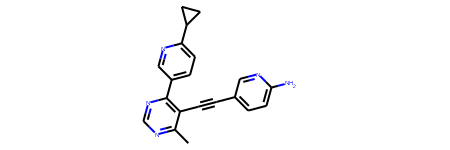

In [3]:
mtor_ligands[666]

In [4]:
# count of rings:
Chem.GetSSSR(mtor_ligands[666])

4

In [5]:
# count of rotatable bonds:
Chem.CalcNumRotatableBonds(mtor_ligands[666])

2

In [6]:
# count of all heavy/non-hydrogen atoms
mtor_ligands[666].GetNumHeavyAtoms()

25

In [7]:
# hydrogen bond acceptors / donors
from rdkit.Chem import rdMolDescriptors as rdescriptors
rdescriptors.CalcNumLipinskiHBA(mtor_ligands[666]), rdescriptors.CalcNumLipinskiHBD(mtor_ligands[666])

(5, 2)

In [8]:
# molecular weight
rdescriptors.CalcExactMolWt(mtor_ligands[666])

327.1483955440001

In [9]:
# topological polar surface area
rdescriptors.CalcTPSA(mtor_ligands[666])

77.58

In [10]:
# octanol-water partition coefficient
Descriptors.MolLogP(mtor_ligands[666])

3.10142

This is about as much as we will need today, there are many more descriptors. Some [more](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors) are in the [RDKit docs](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html). Let's do the current descriptors for the entire set, and load them into a pandas dataframe. This might take a while :)

In [11]:
mtor_rings = [Chem.GetSSSR(l) for l in mtor_ligands]
mtor_rotatable = [Chem.CalcNumRotatableBonds(l) for l in mtor_ligands]
mtor_atomcount = [l.GetNumHeavyAtoms() for l in mtor_ligands]
mtor_hba = [rdescriptors.CalcNumLipinskiHBA(l) for l in mtor_ligands]
mtor_hbd = [rdescriptors.CalcNumLipinskiHBD(l) for l in mtor_ligands]
mtor_molwt = [rdescriptors.CalcExactMolWt(l) for l in mtor_ligands]
mtor_tpsa = [rdescriptors.CalcTPSA(l) for l in mtor_ligands]
mtor_logp = [Descriptors.MolLogP(l) for l in mtor_ligands]

In [12]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 11.7)}) # for bigger graphs

In [13]:
df = pd.DataFrame(data={'set':'mtor', 'rings': mtor_rings,
                        'rotatable': mtor_rotatable, 'atoms': mtor_atomcount,
                        'hba': mtor_hba, 'hbd': mtor_hbd, 'molwt': mtor_molwt,
                        'tpsa': mtor_tpsa, 'logp': mtor_logp})
df

,set,rings,rotatable,atoms,hba,hbd,molwt,tpsa,logp
0,mtor,4,5,30,8,2,443.052210,113.94,3.65160
1,mtor,4,5,28,6,1,390.115047,77.00,4.59912
2,mtor,4,6,29,7,1,406.109961,86.23,4.29930
3,mtor,4,5,30,8,2,443.052210,113.94,3.65160
4,mtor,4,5,31,8,1,457.067860,105.15,3.67590
...,...,...,...,...,...,...,...,...,...
4591,mtor,4,5,30,8,1,426.079804,102.66,2.70500
4592,mtor,4,4,30,7,1,448.020845,93.43,3.48890
4593,mtor,5,4,31,6,1,407.126991,77.13,4.92340
4594,mtor,4,5,28,8,3,381.180090,106.62,1.48800


Ok, that's already a nice hefty table. Let's visualize the values, maybe some [boxplots](https://en.wikipedia.org/wiki/Box_plot)?

<AxesSubplot:>

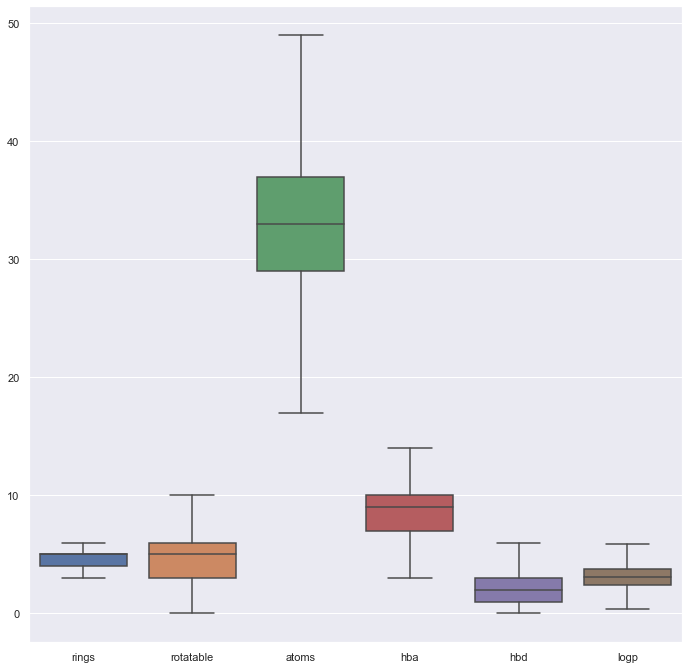

In [14]:
sns.boxplot(data=df[['rings', 'rotatable', 'atoms', 'hba', 'hbd', 'logp']], showfliers=False)

In the above boxplots, the distributions of most descriptors are depicted right next to each other. Molecular weight and TPSA are too off-scale for this.

<AxesSubplot:>

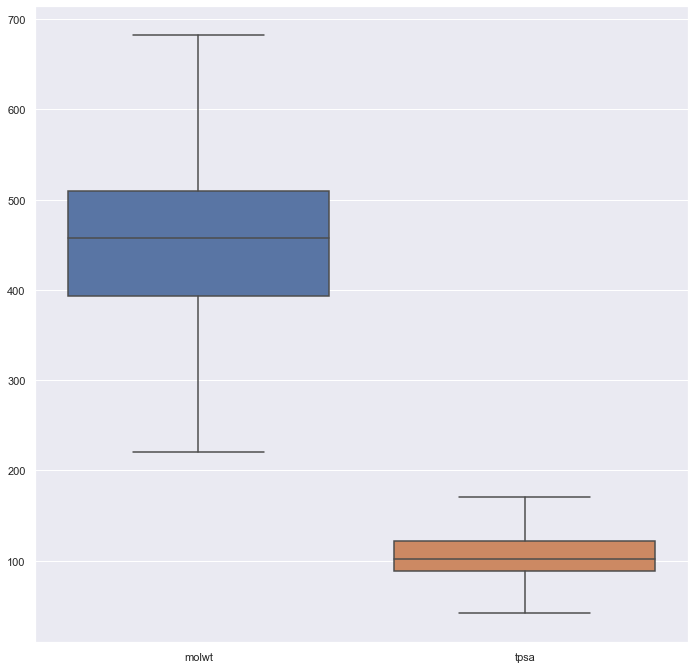

In [15]:
sns.boxplot(data=df[['molwt', 'tpsa']], showfliers = False)

The above two graphs cover the selected descriptors for the mTOR set. However, it would be much better if we had some reference data to compare this set against: how about DrugBank, a database of registered pharmaceuticals?

In [16]:
suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]
len(drugs)

7113

In [17]:
drugbank_rings = [Chem.GetSSSR(l) for l in drugs]
drugbank_rotatable = [Chem.CalcNumRotatableBonds(l) for l in drugs]
drugbank_atomcount = [l.GetNumHeavyAtoms() for l in drugs]
drugbank_hba = [rdescriptors.CalcNumLipinskiHBA(l) for l in drugs]
drugbank_hbd = [rdescriptors.CalcNumLipinskiHBD(l) for l in drugs]
drugbank_molwt = [rdescriptors.CalcExactMolWt(l) for l in drugs]
drugbank_tpsa = [rdescriptors.CalcTPSA(l) for l in drugs]
drugbank_logp = [Descriptors.MolLogP(l) for l in drugs]

In [18]:
df_drugbank = pd.DataFrame(data={'set':'drugs', 'rings': drugbank_rings,
                                 'rotatable': drugbank_rotatable, 'atoms': drugbank_atomcount,
                                 'hba': drugbank_hba, 'hbd': drugbank_hbd, 'molwt': drugbank_molwt,
                                 'tpsa': drugbank_tpsa, 'logp': drugbank_logp})
df_drugbank

,set,rings,rotatable,atoms,hba,hbd,molwt,tpsa,logp
0,drugs,6,66,155,57,31,2178.985813,901.57,-8.11643
1,drugs,6,31,91,32,20,1268.641439,495.89,-3.10570
2,drugs,4,19,74,26,18,1068.426955,435.41,-4.13203
3,drugs,6,38,102,31,20,1429.669818,495.67,-0.50613
4,drugs,1,15,85,23,5,1201.841368,278.80,3.26900
...,...,...,...,...,...,...,...,...,...
7108,drugs,1,0,8,1,1,128.002892,20.23,2.04560
7109,drugs,3,3,24,9,5,340.079432,149.82,-1.32270
7110,drugs,6,14,79,27,13,1114.554641,403.10,1.54710
7111,drugs,0,13,21,5,0,330.147689,83.50,-0.00030


In [19]:
joint_df = pd.concat([df, df_drugbank], ignore_index=True)
joint_df

,set,rings,rotatable,atoms,hba,hbd,molwt,tpsa,logp
0,mtor,4,5,30,8,2,443.052210,113.94,3.65160
1,mtor,4,5,28,6,1,390.115047,77.00,4.59912
2,mtor,4,6,29,7,1,406.109961,86.23,4.29930
3,mtor,4,5,30,8,2,443.052210,113.94,3.65160
4,mtor,4,5,31,8,1,457.067860,105.15,3.67590
...,...,...,...,...,...,...,...,...,...
11704,drugs,1,0,8,1,1,128.002892,20.23,2.04560
11705,drugs,3,3,24,9,5,340.079432,149.82,-1.32270
11706,drugs,6,14,79,27,13,1114.554641,403.10,1.54710
11707,drugs,0,13,21,5,0,330.147689,83.50,-0.00030


In [20]:
melted_df = pd.melt(joint_df, id_vars=['set'], value_vars=['rings', 'rotatable', 'atoms', 'hba', 'hbd', 'logp'])
melted_df

,set,variable,value
0,mtor,rings,4.0000
1,mtor,rings,4.0000
2,mtor,rings,4.0000
3,mtor,rings,4.0000
4,mtor,rings,4.0000
...,...,...,...
70249,drugs,logp,2.0456
70250,drugs,logp,-1.3227
70251,drugs,logp,1.5471
70252,drugs,logp,-0.0003


<AxesSubplot:xlabel='variable', ylabel='value'>

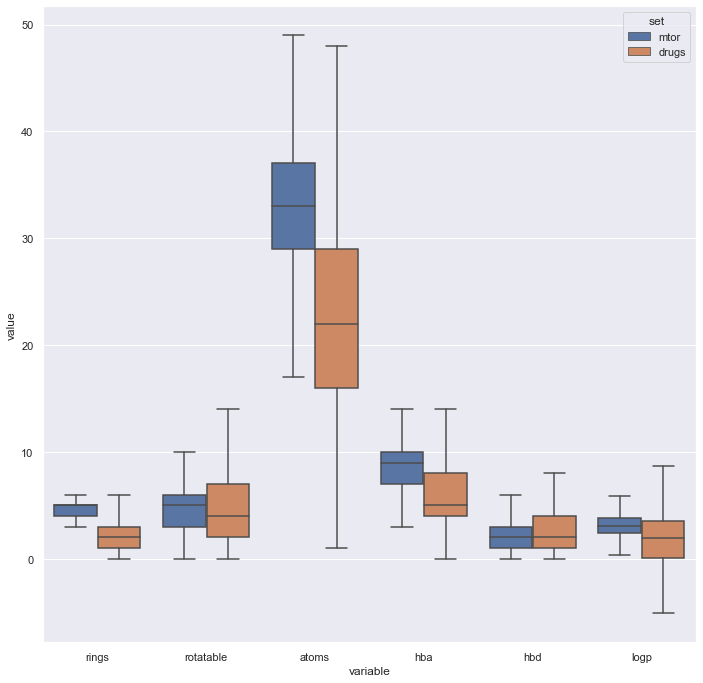

In [21]:
sns.boxplot(y='value', x='variable', hue='set', data=melted_df, showfliers=False)

In [22]:
melted_df2 = pd.melt(joint_df, id_vars=['set'], value_vars=['molwt', 'tpsa'])
melted_df2

,set,variable,value
0,mtor,molwt,443.052210
1,mtor,molwt,390.115047
2,mtor,molwt,406.109961
3,mtor,molwt,443.052210
4,mtor,molwt,457.067860
...,...,...,...
23413,drugs,tpsa,20.230000
23414,drugs,tpsa,149.820000
23415,drugs,tpsa,403.100000
23416,drugs,tpsa,83.500000


<AxesSubplot:xlabel='variable', ylabel='value'>

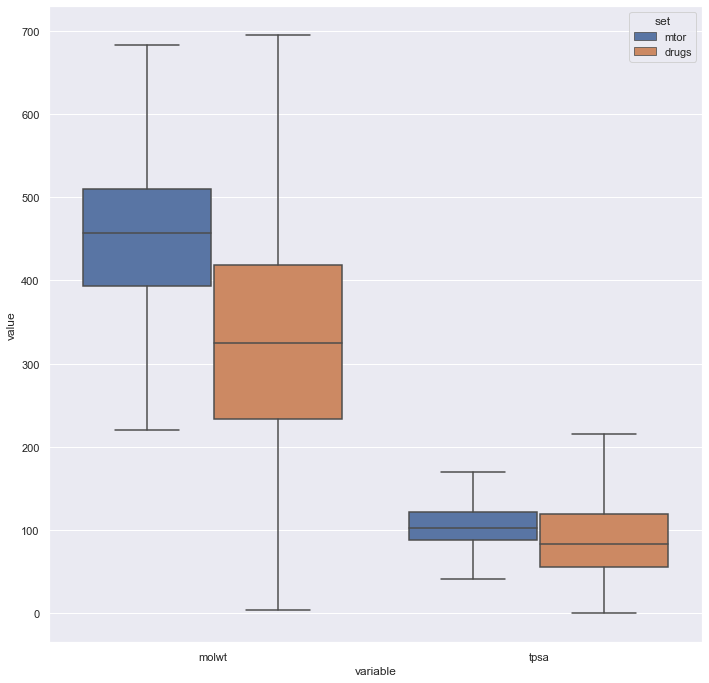

In [23]:
sns.boxplot(y='value', x='variable', hue='set', data=melted_df2, showfliers=False)

In comparison to known therapeutic substances in DrugBank, our set of mTOR ligands tends to have structures with many more rings, well beyond the third quartile ring count in DrugBank. mTOR ligands also have overall much higher number of heavy atoms, and higher molecular weight overall.

Probably the most interesting thing here is the discrepancy in the ratio of hydrogen bond acceptors (hba) to [hydrogen bond](https://en.wikipedia.org/wiki/Hydrogen_bond) donors (hbd) - mTOR inhibitors have a much larger amount of the former, and comparatively smaller amount of the latter. Maybe something to do with the cavity it binds to?

Hydrogen bond acceptors are usually heteroatoms (non H and C atoms, often O, N, S, etc.) that have some free electron pairs for hydrogen atoms to latch onto. Let's try if the observed trends between hydrogen bond acceptors can also be observed on heteroatom-specific descriptors. Since mTOR ligands are generally larger than DrugBank substances, the absolute counts of heteroatoms and heterocycles will probably be influenced by that. Instead, let's make our own descriptor of sorts: ratios of heteroatoms/all_atoms and heterocycles/all_cycles, to gain information about the heteroatom density in the molecules, and whether it reflects the observed differences in hydrogen bond acceptors.

In [24]:
mtor_heteroatoms_ratio = [rdescriptors.CalcNumHeteroatoms(l)/l.GetNumHeavyAtoms() for l in mtor_ligands]
drugbank_heteroatoms_ratio = [rdescriptors.CalcNumHeteroatoms(l)/l.GetNumHeavyAtoms() for l in drugs]
# heterocycles = cycles with heteroatoms
mtor_heterocycles_ratio = [rdescriptors.CalcNumHeterocycles(l)/rdescriptors.CalcNumRings(l)
                           for l in mtor_ligands if rdescriptors.CalcNumRings(l)]
drugbank_heterocycles_ratio = [rdescriptors.CalcNumHeterocycles(l)/rdescriptors.CalcNumRings(l)
                               for l in drugs if rdescriptors.CalcNumRings(l)]

In [25]:
# Put the data into a DataFrame object, one formatted so that we don't need to 'melt' it for mapping into boxplot
# Make an initial dataframe, then extend it by each additional set
df = pd.DataFrame(data=[{'set': 'mtor', 'variable': 'heteroatom_ratio', 'value': x}
                        for x in mtor_heteroatoms_ratio])
df = df.append(pd.DataFrame(data=[{'set': 'drugbank', 'variable': 'heteroatom_ratio', 'value': x}
                                  for x in drugbank_heteroatoms_ratio]), ignore_index=True)
df = df.append(pd.DataFrame(data=[{'set': 'mtor', 'variable': 'heterocycle_ratio', 'value': x}
                                  for x in mtor_heterocycles_ratio]), ignore_index=True)
df = df.append(pd.DataFrame(data=[{'set': 'drugbank', 'variable': 'heterocycle_ratio', 'value': x}
                                  for x in drugbank_heterocycles_ratio]), ignore_index=True)
df

,set,variable,value
0,mtor,heteroatom_ratio,0.366667
1,mtor,heteroatom_ratio,0.250000
2,mtor,heteroatom_ratio,0.275862
3,mtor,heteroatom_ratio,0.366667
4,mtor,heteroatom_ratio,0.354839
...,...,...,...
22431,drugbank,heterocycle_ratio,0.000000
22432,drugbank,heterocycle_ratio,0.000000
22433,drugbank,heterocycle_ratio,0.666667
22434,drugbank,heterocycle_ratio,0.500000


<AxesSubplot:xlabel='variable', ylabel='value'>

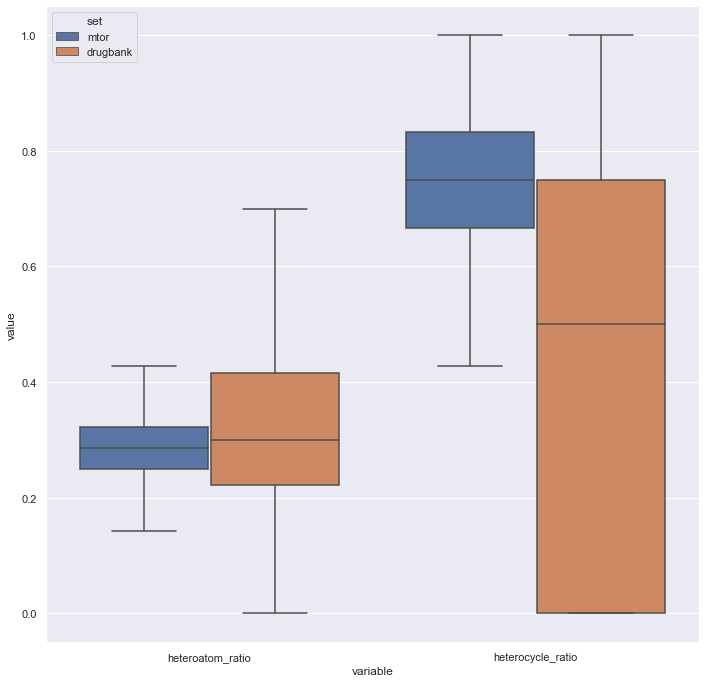

In [26]:
sns.boxplot(y='value', x='variable', hue='set', data=df, showfliers=False)

The overall ratio of heteroatoms within known mTOR ligands seems on par with the relative amount of heteroatoms within known drugs, even somewhat smaller. So, that can't be it. However, more interestingly, almost all cycles in known mTOR ligands contain heteroatoms, while only about half of the cycles in known drugs contain said heteroatoms. And since the known mTOR ligands contain many more rings in general, this may further widen the observed divide in hydrogen bond acceptor counts...

# What to do
 - have a look at the linked materials, also including [the article](http://www.chemicke-listy.cz/docs/full/2017_11_716-723.pdf) from the good ol' leaves. I am sure you were/will be told about descriptors at length from the actual lectures. For the purposes of this exercise, just please make sure you have some general notion of what a molecular descriptor is and what it can be used for
 - apply the aforedescribed methods onto your own dataset. How does DrugBank and mTOR compare to your dataset? Any comments/ideas? Also, if you do not have seaborn, just do "conda install seaborn" in your conda environment, it should sort itself out. If you have some other visualization preferences, with different graph styles and/or different libraries, you can use whatever you are comfortable with.
 - If you notice something interesting about your dataset, try to "zoom" onto the observed discrepancy using additional descriptors, their ratios or visualizations of your choosing. Here, it was the observed large amount of hydrogen bond acceptors followed by calculating heteroatom and heterocycle ratios. For your set, it might be something different. The whole point of this is you trying to follow and investigate the trends in your dataset. If you find everything in line with known drugs in DrugBank, congrats - your ligands seem pretty druglike. If that's the case, just try the heteroatom and heterocycle ratios ;)